In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
import optuna
import mlflow
import mlflow.lightgbm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler('training.log')

# Create formatters and add them to the handlers
console_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_format)
file_handler.setFormatter(file_format)

# Add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Load datasets
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")
test_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_test.csv")

# Drop ID column from training and test data
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")


2024-07-13 12:50:04,826 - __main__ - INFO - Train dataset shape: (11465233, 11)
2024-07-13 12:50:04,826 - __main__ - INFO - Test dataset shape: (7669866, 10)


In [3]:
# Existing interaction features
train_df['Age_Annual_Premium'] = train_df['Age'] * train_df['Annual_Premium']
train_df['Age_Vintage'] = train_df['Age'] * train_df['Vintage']
train_df['Annual_Premium_Vintage'] = train_df['Annual_Premium'] * train_df['Vintage']

# New interaction features
train_df['Age_Region_Code'] = train_df['Age'] * train_df['Region_Code']
train_df['Vintage_Region_Code'] = train_df['Vintage'] * train_df['Region_Code']
train_df['Annual_Premium_Region_Code'] = train_df['Annual_Premium'] * train_df['Region_Code']

logger.info(f"Interaction features created: Age_Annual_Premium, Age_Vintage, Annual_Premium_Vintage, Age_Region_Code, Vintage_Region_Code, Annual_Premium_Region_Code")

# Perform target encoding
target_enc = TargetEncoder(cols=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])
train_df = target_enc.fit_transform(train_df, train_df['Response'])

logger.info(f"Target encoding performed for categorical variables.")

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(train_df[['Age', 'Annual_Premium', 'Vintage']])
poly_feature_names = poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])

# Ensure the polynomial feature names are unique
poly_feature_names_unique = [f"{name}_{i}" for i, name in enumerate(poly_feature_names)]

poly_df = pd.DataFrame(poly_features, columns=poly_feature_names_unique)

# Concatenate polynomial features with train_df
train_df = pd.concat([train_df, poly_df], axis=1)

# Drop the original columns to prevent duplication
train_df = train_df.loc[:,~train_df.columns.duplicated()]

logger.info(f"Polynomial features created with degree 2 for Age, Annual_Premium, and Vintage")


2024-07-13 12:50:05,065 - __main__ - INFO - Interaction features created: Age_Annual_Premium, Age_Vintage, Annual_Premium_Vintage, Age_Region_Code, Vintage_Region_Code, Annual_Premium_Region_Code
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X

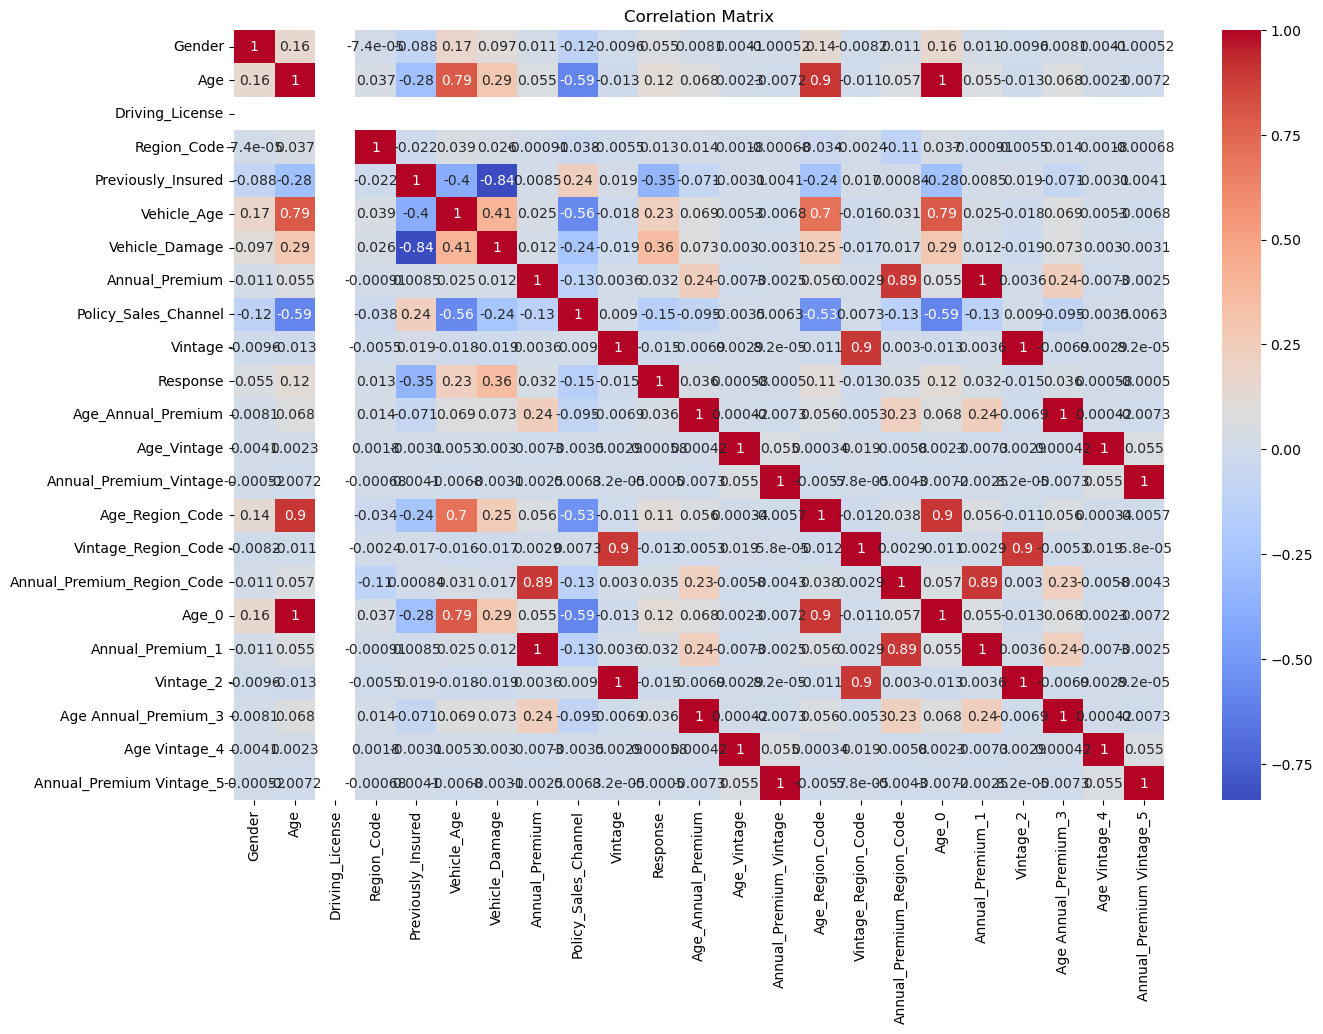

In [4]:
# Correlation matrix
corr_matrix = train_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [10]:
# Splitting the data into features and target variable
X = train_df.drop(columns=['Response'])
y = train_df['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

logger.info(f"Training set shape: {X_train.shape}")
logger.info(f"Validation set shape: {X_val.shape}")


2024-07-13 12:57:59,222 - __main__ - INFO - Training set shape: (9172186, 22)
2024-07-13 12:57:59,223 - __main__ - INFO - Validation set shape: (2293047, 22)


In [12]:
import optuna
import pandas as pd
import joblib
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'max_depth': trial.suggest_int('max_depth', 6, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Adding early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=100, first_metric_only=True, verbose=False)

    model = lgb.train(
        params, 
        train_data, 
        num_boost_round=1000, 
        valid_sets=[train_data, val_data], 
        callbacks=[early_stopping_callback]
    )

    val_preds = model.predict(X_val)
    auc = roc_auc_score(y_val, val_preds)
    
    return auc

In [13]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

# Save the best trial parameters
best_params = study.best_trial.params
pd.DataFrame([best_params]).to_csv('best_params.csv', index=False)

# Load the best parameters from Optuna study
best_params = pd.read_csv('best_params.csv').to_dict(orient='records')[0]


[I 2024-07-13 12:58:04,654] A new study created in memory with name: no-name-ada963ee-2782-4561-a7ae-186b73f9f14f


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 13:14:13,146] Trial 0 finished with value: 0.8812965138798756 and parameters: {'learning_rate': 0.05453907210284429, 'num_leaves': 92, 'max_depth': 9, 'min_data_in_leaf': 12, 'bagging_fraction': 0.69578307862956, 'feature_fraction': 0.6649832039035714, 'lambda_l1': 0.7919093105822196, 'lambda_l2': 0.6787916876803611, 'bagging_freq': 7}. Best is trial 0 with value: 0.8812965138798756.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-07-13 13:29:32,383] Trial 1 finished with value: 0.8811430372637982 and parameters: {'learning_rate': 0.06954601123882412, 'num_leaves': 66, 'max_depth': 7, 'min_data_in_leaf': 38, 'bagging_fraction': 0.5969034976530574, 'feature_fraction': 0.795891941016659, 'lambda_l1': 0.23734702478875003, 'lambda_l2': 0.5107433779553946, 'bagging_freq': 1}. Best is trial 0 with value: 0.8812965138798756.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 13:45:15,772] Trial 2 finished with value: 0.8813332581294541 and parameters: {'learning_rate': 0.08855042052013305, 'num_leaves': 103, 'max_depth': 13, 'min_data_in_leaf': 19, 'bagging_fraction': 0.6204114118550511, 'feature_fraction': 0.6486410273036127, 'lambda_l1': 0.7795009902505062, 'lambda_l2': 0.6436640210046373, 'bagging_freq': 2}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 14:00:24,873] Trial 3 finished with value: 0.8810169614733919 and parameters: {'learning_rate': 0.07024316988615242, 'num_leaves': 61, 'max_depth': 15, 'min_data_in_leaf': 22, 'bagging_fraction': 0.5179705590995474, 'feature_fraction': 0.6121603266280269, 'lambda_l1': 0.8658960197210592, 'lambda_l2': 0.19752069849057818, 'bagging_freq': 7}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-13 14:16:27,434] Trial 4 finished with value: 0.8810469208706995 and parameters: {'learning_rate': 0.034909758781303625, 'num_leaves': 113, 'max_depth': 9, 'min_data_in_leaf': 36, 'bagging_fraction': 0.6106058407015291, 'feature_fraction': 0.5657686773545827, 'lambda_l1': 0.1254538978737575, 'lambda_l2': 0.6322950558417401, 'bagging_freq': 3}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3612
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 14:31:57,139] Trial 5 finished with value: 0.8812319180445127 and parameters: {'learning_rate': 0.058106205462493656, 'num_leaves': 99, 'max_depth': 14, 'min_data_in_leaf': 47, 'bagging_fraction': 0.6285872448064335, 'feature_fraction': 0.6738921202183998, 'lambda_l1': 0.3952994774143588, 'lambda_l2': 0.06852182748600244, 'bagging_freq': 6}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3612
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 14:47:23,944] Trial 6 finished with value: 0.881107842157773 and parameters: {'learning_rate': 0.06025576039360711, 'num_leaves': 109, 'max_depth': 15, 'min_data_in_leaf': 49, 'bagging_fraction': 0.5047744625131083, 'feature_fraction': 0.7980498783286167, 'lambda_l1': 0.24238504497614066, 'lambda_l2': 0.4872014583642409, 'bagging_freq': 4}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3612
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 15:03:06,200] Trial 7 finished with value: 0.8805853719096758 and parameters: {'learning_rate': 0.03316988559550532, 'num_leaves': 71, 'max_depth': 8, 'min_data_in_leaf': 47, 'bagging_fraction': 0.5671024216011511, 'feature_fraction': 0.5071153962854775, 'lambda_l1': 0.19288325295857478, 'lambda_l2': 0.7370360461506658, 'bagging_freq': 5}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[I 2024-07-13 15:19:43,622] Trial 8 finished with value: 0.881260262223513 and parameters: {'learning_rate': 0.04366316248616438, 'num_leaves': 110, 'max_depth': 16, 'min_data_in_leaf': 36, 'bagging_fraction': 0.6497377286243443, 'feature_fraction': 0.6137825117909979, 'lambda_l1': 0.8661290828407364, 'lambda_l2': 0.7388832555204689, 'bagging_freq': 4}. Best is trial 2 with value: 0.8813332581294541.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3614
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


[W 2024-07-13 15:22:18,917] Trial 9 failed with parameters: {'learning_rate': 0.09633749526198943, 'num_leaves': 119, 'max_depth': 14, 'min_data_in_leaf': 30, 'bagging_fraction': 0.5134741188516239, 'feature_fraction': 0.7323314193091746, 'lambda_l1': 0.19039464169517917, 'lambda_l2': 0.1391032805161524, 'bagging_freq': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\paulo\AppData\Local\Temp\ipykernel_43636\636202704.py", line 33, in objective
    model = lgb.train(
            ^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\lightgbm\engine.py", line 282, in train
    evaluation_result_list.extend(booster.eval_train(feval))
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anacon

KeyboardInterrupt: 